# June 17th, 2021

**Motivation**: Using Mice object, apply agglomerative hierarchical clustering to fMRI data using all subjects.  Brainrender + embed html </br>

In [1]:
# HIDE CODE


import os
import ants
import nrrd

import sys
import collections
import numpy as np
import pandas as pd
import nibabel as nib
import networkx as nx
import operator as op
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# tmp dir
tmp_dir = pjoin(os.environ['HOME'], 'Dropbox/git/jb-Ca-fMRI/tmp')

# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from analysis.network import *
from utils.plotting import *
from model.mouse import Mice

# Allen
allen_ws = pjoin(os.environ['HOME'], 'Documents/workspaces/allen')
allen_path = pjoin(allen_ws, 'MouseConnectivity')
os.makedirs(allen_path, exist_ok=True)
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


def trim_axs(axes, n):
    axs = axes.flat
    for ax in axs[n:]:
        ax.remove()
    return axs[:n]


def reset_ants_img(img: Union[np.ndarray, ants.ANTsImage], dtype=float, origin=0.0, spacing=1.0):
    ndims = len(img.shape)
    if isinstance(img, ants.ANTsImage):
        img = img.numpy()
    return ants.from_numpy(img.astype(dtype), origin=[origin]*ndims, spacing=[spacing]*ndims)


def add_children(graph: nx.DiGraph(), src_id: int, level: int, structure_tree):
    src = structure_tree.get_structures_by_id([src_id])[0]
    children = structure_tree.children([src_id])[0]
    for child in children:
        src_name = '\n'.join(src['name'].split(' '))
        tgt_name = '\n'.join(child['name'].split(' '))
        graph.add_node(tgt_name, lvl=level)
        graph.add_edge(src_name, tgt_name)
    return graph, children


def make_tree_graph(root: str, mcc: MouseConnectivityCache, n_levels: int = 3):
    structure_tree = mcc.get_structure_tree()
    structure = structure_tree.get_structures_by_name([root])[0]
    
    g = nx.DiGraph()
    g.add_node('\n'.join(structure['name'].split(' ')), lvl=0)

    dend = {}
    for lvl in range(n_levels):
        if lvl == 0:
            src_ids = [structure['id']]
        else:
            new_leaves = []
            for i in src_ids:
                g, children = add_children(
                    graph=g,
                    src_id=i,
                    level=lvl,
                    structure_tree=structure_tree,
                )
                for child in children:
                    new_leaves.append(child['id'])
            src_ids = new_leaves
        dend[lvl] = src_ids
 
    return g, dend


def reorient_arr(x: np.ndarray, tr_axes: Tuple = (2, 1, 0)):
    if len(x.shape) == 4:
        tr_axes += (3,)
    return np.transpose(x, tr_axes)[::-1]


def mask_left_right(mask: np.ndarray, left_right_axis: int = 2):
    npix = mask.shape[left_right_axis]
    coverage = int(np.ceil(npix/2))
    slices_l = tuple(
        slice(0, coverage) if i == left_right_axis else slice(mask.shape[i])
        for i in range(len(mask.shape))
    )
    slices_r = tuple(
        slice(npix-coverage, npix) if i == left_right_axis else slice(mask.shape[i])
        for i in range(len(mask.shape))
    )
    mask_l = mask.copy().astype(bool)
    mask_r = mask.copy().astype(bool)
    mask_l[slices_r] = 0
    mask_r[slices_l] = 0
    
    return mask_l.astype(bool), mask_r.astype(bool)


from time import time
from sklearn.cluster import KMeans
import sklearnex


def kmeans_parcellation(
    mask: np.ndarray,
    num_regions: int = 256,
    symmetrize: bool = False,
    left_right_axis: int = 2,
    random_state: int = 42, ):
    
    sklearnex.patch_sklearn()
    mask_l, mask_r = mask_left_right(mask, left_right_axis)
    
    if symmetrize:
        mask_r_full = mask_r.copy()
        mask_l_full = mask_l.copy()
        mask_r_full[slices_l] = np.flip(mask_r[slices_r], axis=left_right_axis)
        mask_l_full[slices_r] = np.flip(mask_l[slices_l], axis=left_right_axis)
        mask_sym = np.logical_and(mask_r_full, mask_l_full)
        
        mask_l = mask_sym.copy().astype(bool)
        mask_r = mask_sym.copy().astype(bool)
        mask_l[slices_r] = 0
        mask_r[slices_l] = 0
        
        # do left
        atlas_kmeans, cluster_centers = _do_kmeans(mask_l, num_regions, random_state)
        
        # mirror symmetry clusters to right hemisphere
        for region_id in np.unique(atlas_kmeans[atlas_kmeans > 0]):
            
            region_id_r = region_id + num_regions
            flipped = np.flip(atlas_kmeans[slices_l], axis=left_right_axis)
            atlas_kmeans[slices_r][flipped == region_id] = region_id_r
            
            # get center for right cluster
            _ctr = cluster_centers[region_id].copy()
            delta = npix/2 - _ctr[left_right_axis]
            _ctr[left_right_axis] += 2*delta - 1
            cluster_centers[region_id_r] = _ctr

    else:
        atlas_kmeans_l, cluster_centers_l = _do_kmeans(mask_l, num_regions, random_state)
        atlas_kmeans_r, cluster_centers_r = _do_kmeans(mask_r, num_regions, random_state)
        
        atlas_kmeans_r += num_regions 
        cluster_centers_r = {i+num_regions: ctr for i, ctr in cluster_centers_r.items()}
        
        atlas_kmeans = atlas_kmeans_l.copy()
        atlas_kmeans[mask_r] = atlas_kmeans_r[mask_r]
        cluster_centers = {**cluster_centers_l, **cluster_centers_r}

    sklearnex.unpatch_sklearn()
    output = {
        'atlas_kmeans': atlas_kmeans.astype(int),
        'cluster_centers': cluster_centers,
        'mask_l': mask_l.astype(bool),
        'mask_r': mask_r.astype(bool),
    }
    return output


def _do_kmeans(x, num_regions, random_state):
    nonzero_voxels = list(zip(*np.where(x.astype(bool))))
    nonzero_voxels = np.reshape(nonzero_voxels, (-1, len(x.shape)))
    nonzero_voxels = nonzero_voxels.astype(int)

    kmeans = KMeans(
        n_clusters=num_regions,
        random_state=random_state,
    ).fit(nonzero_voxels.astype(float))
    roi = kmeans.predict(nonzero_voxels.astype(float))

    roi_unique = []
    for lbl in roi:
        if lbl not in roi_unique:
            roi_unique.append(lbl)
    mapping = {lbl: i+1 for i, lbl in enumerate(roi_unique)}

    roi_relabeld = np.zeros_like(roi)
    for lbl in roi_unique:
        roi_relabeld[roi == lbl] = mapping[lbl]

    atlas_kmeans_dict = defaultdict(list)
    for voxel, lbl in zip(nonzero_voxels, roi_relabeld):
        atlas_kmeans_dict[lbl].append(tuple(voxel))
    atlas_kmeans_dict = dict(atlas_kmeans_dict)

    atlas_kmeans = np.zeros(x.shape, dtype=int)
    for region_id, voxel_list in atlas_kmeans_dict.items():
        atlas_kmeans[tuple(zip(*voxel_list))] = region_id

    cluster_centers = {mapping[lbl]: kmeans.cluster_centers_[lbl] for lbl in roi_unique}
    
    return atlas_kmeans, cluster_centers


def translate_labels(labels: List[str], mcc: MouseConnectivityCache, forward: bool = True):
    labels = list(labels) if not isinstance(labels, (list, tuple, dict)) else labels
    structure_tree = mcc.get_structure_tree()

    left_right = []
    aux_ids = []
    
    if forward:
        structure_ids = []
        for label in labels:
            try:
                lr, structure_id, aux_id = tuple(map(lambda x: int(x), label.split('-')))
            except ValueError:
                lr, structure_id = tuple(map(lambda x: int(x), label.split('-')))
                aux_id = None
            left_right.append('L' if lr == 0 else 'R')
            structure_ids.append(structure_id)
            aux_ids.append(aux_id)

        structures = structure_tree.get_structures_by_id(structure_ids)
        translated = [
            '{:s}-{:s}'.format(lr, struct['name']) if aux_id is None else
            '{:s}-{:s}-{:d}'.format(lr, struct['name'], aux_id)
            for lr, struct, aux_id in zip(left_right, structures, aux_ids)
        ]  
    else:
        structure_names = []
        for label in labels:
            try:
                lr, structure_name, aux_id = label.split('-')
                aux_id = int(aux_id)
            except ValueError:
                lr, structure_name = label.split('-')
                aux_id = None
            left_right.append(0 if lr == 'L' else 1)
            structure_names.append(structure_name)
            aux_ids.append(aux_id)
                
        structures = structure_tree.get_structures_by_name(structure_names)
        translated = [
            '{:d}-{:d}'.format(lr, struct['id']) if aux_id is None else
            '{:d}-{:d}-{:d}'.format(lr, struct['id'], aux_id)
            for lr, struct, aux_id in zip(left_right, structures, aux_ids)
        ]
    return translated


def load_allen(ws_dir: str, mode: str = 'MouseConnectivity', resolution: int = 100):
    manifest_file = pjoin(ws_dir, mode, 'manifest.json')
    mcc = MouseConnectivityCache(resolution=resolution, manifest_file=manifest_file)
    structure_tree = mcc.get_structure_tree()
    
    root = structure_tree.get_structures_by_name(['root'])[0]
    cerebrum = structure_tree.get_structures_by_name(['Cerebrum'])[0]
    isocortex = structure_tree.get_structures_by_name(['Isocortex'])[0]

    template, template_info = mcc.get_template_volume()
    annot, annot_info = mcc.get_annotation_volume()

    root_mask, root_mask_info = mcc.get_structure_mask(root['id'])
    cerebrum_mask, cerebrum_mask_info = mcc.get_structure_mask(cerebrum['id'])
    isocortex_mask, isocortex_mask_info = mcc.get_structure_mask(isocortex['id'])
    
    output = {
        'manifest_file': manifest_file,
        'mcc': mcc,
        'structure_tree': structure_tree,
        
        'root': root,
        'cerebrum': cerebrum,
        'isocortex': isocortex,
        
        'template': template,
        'template_info': template_info,
        
        'annot': annot,
        'annot_info': annot_info,
        
        'root_mask': root_mask,
        'root_mask_info': root_mask_info,
        
        'cerebrum_mask': cerebrum_mask,
        'cerebrum_mask_info': cerebrum_mask_info,
        
        'isocortex_mask': isocortex_mask,
        'isocortex_mask_info': isocortex_mask_info,
    }
    return output


def plot_parcellation(
    parcellation: np.ndarray,
    mask_l: np.ndarray,
    mask_r: np.ndarray,
    root_mask: np.ndarray,
    figsize=(6, 4),
    cmap='turbo', ):

    sns.set_style('whitegrid')
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    for i in range(2):
        for j in range(3):
            x = parcellation.copy()

            if i == 0:
                x[mask_r] = 0
                label = 'left\n'
            else:
                x[mask_l] = 0
                # x[x != 0] -= int(np.max(parcellation) // 2)
                label = 'right\n'

            if j == 0:
                title = 'coronal'
            elif j == 1:
                title = 'axial'
            else:
                title = 'saggital'

            data2plt = np.ma.masked_where(~root_mask.astype(bool), x)
            axes[i, j].imshow(data2plt.mean(j), cmap=cmap)

            list(map(lambda x: x.set_visible(False), axes[i, j].spines.values()))
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

            if i == 0:
                axes[i, j].set_title(title, fontsize=17, y=1.2)
            else:
                axes[i, j].set_title('')
            if j == 0:
                axes[i, j].set_ylabel(label, fontsize=17)

    fig.tight_layout()
    plt.show()
    
    return fig, axes


def plot_registration(
    fixed: np.ndarray,
    moving: np.ndarray,
    warped: np.ndarray,
    figsize=(6, 8), ):
    
    sns.set_style('white')
    fig, axes = plt.subplots(3, 3, figsize=figsize)

    for i in range(3):
        for j in range(3):       
            if i == 0:
                x = fixed.numpy()
                label = 'fixed'
            elif i == 1:
                x = moving.numpy()
                label = 'moving'
            else:
                x = warped.numpy()
                label = 'warped'

            if i == 0:
                if j == 0:
                    top_title = 'axis = {:d}\n(coronal)'.format(j)
                elif j == 1:
                    top_title = 'axis = {:d}\n(axial)'.format(j)
                else:
                    top_title = 'axis = {:d}\n(saggital)'.format(j)
                axes[i, j].set_title(top_title, y=1.1, fontsize=13)

            if j == 0:
                axes[i, j].set_ylabel(label + '\n', fontsize=13)

            data2plt = x.mean(j)
            axes[i, j].imshow(data2plt)

            _ = list(map(lambda x: x.set_visible(False), axes[i, j].spines.values()))
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

    msg = 'Plotting averaged data across different dimensions\n\n'
    msg += '1st row (fixed):  Average template,    shape = {}\n'.format(fixed.shape)
    msg += '2nd row (moving):  Anatomical data,    shape = {}\n'.format(moving.shape)
    msg += '3rd row (warped):  Anatomical data,    shape = {}'.format(warped.shape)
    plt.suptitle(msg, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    return fig, axes

In [3]:
import allensdk
print(allensdk.__version__)

2.11.2


## Load Allen data

In [4]:
allen = load_allen(allen_ws)

In [5]:
mice = Mice()

## Get parcellation & ROI masks

In [6]:
num_regions = 64

parcellation = kmeans_parcellation(
    mask=allen['isocortex_mask'],
    num_regions=num_regions,
    symmetrize=False,
    left_right_axis=2,
)

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [7]:
atlas_kmeans_eroded = np.zeros_like(parcellation['atlas_kmeans'])

radius = 5

accepted = 0
rejected = 0
for region_id, ctr in parcellation['cluster_centers'].items():
    for voxel in list(zip(*np.where(parcellation['atlas_kmeans'] == region_id))):
        dist = np.linalg.norm(ctr - voxel)
        if dist < radius:
            atlas_kmeans_eroded[voxel] = region_id
            accepted += 1
        else:
            rejected += 1

accepted /= parcellation['atlas_kmeans'].astype(bool).sum()
rejected /= parcellation['atlas_kmeans'].astype(bool).sum()
accepted *= 100
rejected *= 100

accepted, rejected

(52.5327599496937, 47.4672400503063)

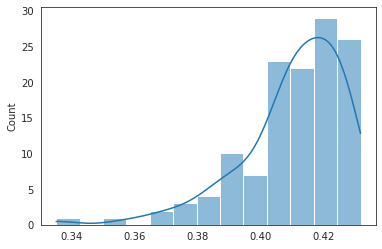

In [8]:
x = atlas_kmeans_eroded.copy().astype(float)
vals, percentages = [], []
for region_id in np.unique(x[x > 0]):
    vals.append((x == region_id).sum())
    size = (x == region_id).sum() / allen['isocortex_mask'].sum()
    if size >= 0.5:
        print('bad', region_id)
        break
    percentages.append(size * 100)
sns.histplot(percentages, kde=True);

In [9]:
np.min(percentages), np.max(percentages), np.std(percentages)

(0.33510487240861697, 0.43166051361109986, 0.01654291860323572)

In [10]:
np.min(vals), np.max(vals), np.var(vals)

(413, 532, 415.68359375)

In [11]:
selected_names = [
    'Striatum',
    'Pallidum',
    'Olfactory areas',
    'Cortical subplate',
    'Hippocampal formation',
    'Isocortex',
]

root_mask_l, root_mask_r = mask_left_right(allen['root_mask'])
selected_structures = allen['structure_tree'].get_structures_by_name(selected_names)

roi_masks = {}
for structure_dict in selected_structures:
    print('id: {:d},\tname: {:s}'.format(structure_dict['id'], structure_dict['name']))
    if structure_dict['name'] == 'Isocortex':
        for region_id_l in range(1, num_regions+1):
            region_id_r = region_id_l + num_regions
            _mask_l = atlas_kmeans_eroded == region_id_l
            _mask_r = atlas_kmeans_eroded == region_id_r
            roi_masks['0-{:d}-{:d}'.format(structure_dict['id'], region_id_l)] = _mask_l.astype(bool)
            roi_masks['1-{:d}-{:d}'.format(structure_dict['id'], region_id_r)] = _mask_r.astype(bool)
    else:
        _mask = allen['mcc'].get_structure_mask(structure_dict['id'])[0]
        _mask_l = np.logical_and(_mask, root_mask_l)
        _mask_r = np.logical_and(_mask, root_mask_r)
        roi_masks['0-{:d}'.format(structure_dict['id'])] = _mask_l.astype(bool)
        roi_masks['1-{:d}'.format(structure_dict['id'])] = _mask_r.astype(bool)

id: 477,	name: Striatum
id: 803,	name: Pallidum
id: 698,	name: Olfactory areas
id: 703,	name: Cortical subplate
id: 1089,	name: Hippocampal formation
id: 315,	name: Isocortex


## Hierarchical

In [12]:
df = pd.read_pickle(pjoin(tmp_dir, 'func_data.df'))
df.shape

(3187800, 7)

In [13]:
df_table = {}

for key, (subject, session, run) in mice.looper.items():
    selected_df = df.loc[
        (df.subject == subject) &
        (df.session == session) &
        (df.run == run)
    ]
    if len(selected_df):
        df_table[key] = selected_df.pivot(index='timepoint', columns='region_id', values='bold')

node_labels = list(df_table.values())[0].columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

### Combine all data

In [14]:
df_combined = pd.concat(df_table.values())
df_combined.shape

(23100, 138)

In [15]:
corr = 1 - sp_dist.pdist(df_combined.values.T, metric='correlation')
corr = sp_dist.squareform(corr)
np.fill_diagonal(corr, 0.0)

corr.shape

(138, 138)

In [16]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [17]:
percentiles = [30, 25, 20, 18, 15, 10]
corrs = get_corrs(df_combined, percentiles=percentiles, positive_only=False)

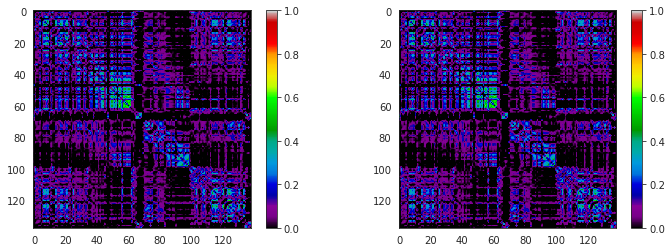

In [18]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.imshow(corr, cmap='nipy_spectral', vmin=0, vmax=1)
plt.colorbar()

plt.subplot(122)
plt.imshow(corrs['pearson_corr'], cmap='nipy_spectral', vmin=0, vmax=1)
plt.colorbar()

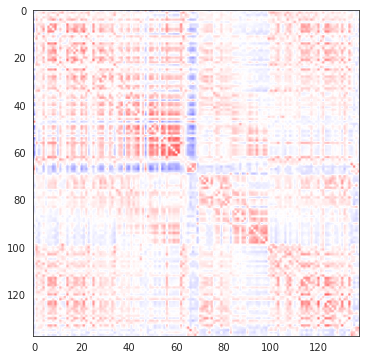

In [19]:
plt.figure(figsize=(8, 6))
plt.imshow(corr, cmap='bwr', vmin=-1, vmax=1)

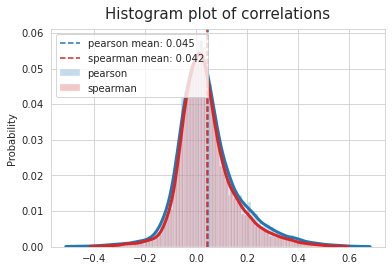

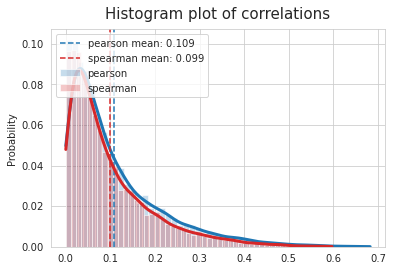

In [20]:
_ = plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr']],
    labels=['pearson', 'spearman'],
    colors=['C0', 'C3'],
    positive_only=False,
    figsize=(6, 4),
)
_ = plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr']],
    labels=['pearson', 'spearman'],
    colors=['C0', 'C3'],
    positive_only=True,
    figsize=(6, 4),
)

### Hierarchical clustering

In [21]:
from IPython.display import display
from analysis.hierarchical import *

### Find best metric

In [22]:
metrics = [
    'braycurtis',
    'canberra',
    'chebyshev',
    'correlation',
    'cosine',
    'dice',
    'euclidean',
    'hamming',
    'jaccard',
    'jensenshannon',
    'kulsinski',
    'mahalanobis',
    'matching',
    'minkowski',
    'rogerstanimoto',
    'russellrao',
    'seuclidean',
    'sokalmichener',
    'sokalsneath',
    'yule',
]
skip = [
    'dice',
    'hamming',
    'jaccard',
    'cityblock',
    'jensenshannon',
    'kulsinski',
    'mahalanobis',
    'matching',
    'rogerstanimoto',
    'russellrao',
    'sokalmichener',
    'sokalsneath',
    'yule',
    'chebyshev',
    'sqeuclidean',
    'minkowski',
]

----------------------------------------------------------------------
----------------------------------------------------------------------
			 braycurtis
----------------------------------------------------------------------
----------------------------------------------------------------------


C1,"['L-Isocortex-6', 'L-Isocortex-7', 'L-Isocortex-14', 'L-Isocortex-15', 'L-Isocortex-17', 'L-Isocortex-21', 'L-Isocortex-24', 'L-Isocortex-25', 'L-Isocortex-26', 'L-Isocortex-28', 'L-Isocortex-31', 'L-Isocortex-34', 'L-Isocortex-36', 'L-Isocortex-37', 'L-Isocortex-39', 'R-Isocortex-69', 'R-Isocortex-74', 'R-Isocortex-79', 'R-Isocortex-80', 'R-Isocortex-81', 'R-Isocortex-82', 'R-Isocortex-86', 'R-Isocortex-89', 'R-Isocortex-90', 'R-Isocortex-91', 'R-Isocortex-92', 'R-Isocortex-93', 'R-Isocortex-94', 'R-Isocortex-96', 'R-Isocortex-99', 'R-Isocortex-101', 'R-Isocortex-102', 'R-Isocortex-103', 'R-Isocortex-104', 'R-Isocortex-105', 'R-Isocortex-109', 'R-Isocortex-110', 'R-Isocortex-111', 'R-Isocortex-112']"
C2,"['L-Cortical subplate', 'R-Cortical subplate', 'L-Hippocampal formation', 'R-Hippocampal formation', 'L-Isocortex-2', 'L-Isocortex-3', 'L-Isocortex-4', 'L-Isocortex-5', 'L-Isocortex-9', 'L-Isocortex-10', 'L-Isocortex-11', 'L-Isocortex-13', 'L-Isocortex-18', 'L-Isocortex-20', 'L-Isocortex-22', 'L-Isocortex-30', 'L-Isocortex-43', 'L-Isocortex-51', 'L-Isocortex-57', 'L-Olfactory areas', 'R-Olfactory areas', 'L-Pallidum', 'R-Pallidum', 'R-Isocortex-65', 'R-Isocortex-66', 'R-Isocortex-68', 'R-Isocortex-70', 'R-Isocortex-71', 'R-Isocortex-72', 'R-Isocortex-75', 'R-Isocortex-76', 'R-Isocortex-77', 'R-Isocortex-84', 'R-Isocortex-85', 'R-Isocortex-87', 'R-Isocortex-98', 'R-Isocortex-113', 'R-Isocortex-120', 'L-Striatum', 'R-Striatum']"
C3,"['L-Isocortex-1', 'L-Isocortex-8', 'L-Isocortex-12', 'L-Isocortex-16', 'L-Isocortex-19', 'L-Isocortex-23', 'L-Isocortex-27', 'L-Isocortex-29', 'L-Isocortex-32', 'L-Isocortex-33', 'L-Isocortex-35', 'L-Isocortex-38', 'L-Isocortex-40', 'L-Isocortex-41', 'L-Isocortex-42', 'L-Isocortex-44', 'L-Isocortex-45', 'L-Isocortex-46', 'L-Isocortex-47', 'L-Isocortex-48', 'L-Isocortex-49', 'L-Isocortex-50', 'L-Isocortex-52', 'L-Isocortex-53', 'L-Isocortex-54', 'L-Isocortex-55', 'L-Isocortex-56', 'L-Isocortex-58', 'L-Isocortex-59', 'L-Isocortex-60', 'L-Isocortex-61', 'L-Isocortex-62', 'L-Isocortex-63', 'L-Isocortex-64', 'R-Isocortex-67', 'R-Isocortex-73', 'R-Isocortex-78', 'R-Isocortex-83', 'R-Isocortex-88', 'R-Isocortex-95', 'R-Isocortex-97', 'R-Isocortex-100', 'R-Isocortex-106', 'R-Isocortex-107', 'R-Isocortex-108', 'R-Isocortex-114', 'R-Isocortex-115', 'R-Isocortex-116', 'R-Isocortex-117', 'R-Isocortex-118', 'R-Isocortex-119', 'R-Isocortex-121', 'R-Isocortex-122', 'R-Isocortex-123', 'R-Isocortex-124', 'R-Isocortex-125', 'R-Isocortex-126', 'R-Isocortex-127', 'R-Isocortex-128']"


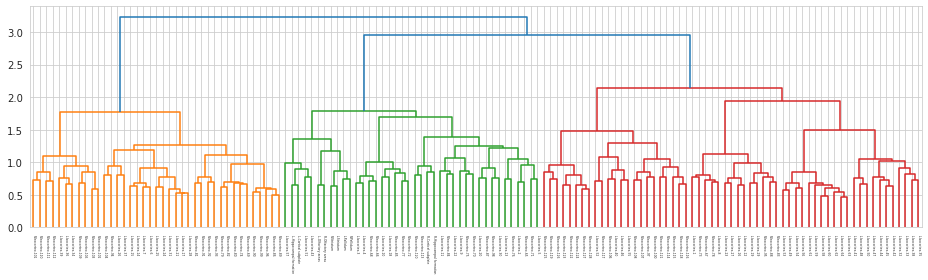

C0,"['(39)', '(40)']"
C1,"['(23)', '(14)', '(22)']"


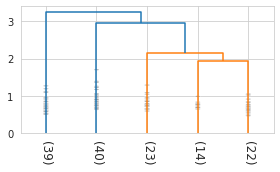

C0,['(39)']
C1,"['(11)', '(29)']"
C2,"['(23)', '(14)', '(22)']"


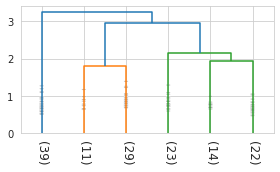

C1,"['(11)', '(28)']"
C2,"['(11)', '(29)']"
C3,"['(23)', '(14)', '(22)']"


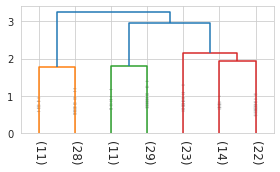






----------------------------------------------------------------------
----------------------------------------------------------------------
			 canberra
----------------------------------------------------------------------
----------------------------------------------------------------------


C1,"['L-Cortical subplate', 'R-Cortical subplate', 'L-Hippocampal formation', 'R-Hippocampal formation', 'L-Olfactory areas', 'R-Olfactory areas', 'L-Pallidum', 'R-Pallidum', 'L-Striatum', 'R-Striatum']"
C2,"['L-Isocortex-6', 'L-Isocortex-7', 'L-Isocortex-11', 'L-Isocortex-12', 'L-Isocortex-14', 'L-Isocortex-15', 'L-Isocortex-16', 'L-Isocortex-17', 'L-Isocortex-21', 'L-Isocortex-22', 'L-Isocortex-24', 'L-Isocortex-25', 'L-Isocortex-26', 'L-Isocortex-28', 'L-Isocortex-31', 'L-Isocortex-34', 'L-Isocortex-36', 'L-Isocortex-37', 'L-Isocortex-39', 'L-Isocortex-43', 'L-Isocortex-51', 'L-Isocortex-57', 'R-Isocortex-69', 'R-Isocortex-74', 'R-Isocortex-79', 'R-Isocortex-80', 'R-Isocortex-81', 'R-Isocortex-82', 'R-Isocortex-84', 'R-Isocortex-86', 'R-Isocortex-89', 'R-Isocortex-90', 'R-Isocortex-91', 'R-Isocortex-92', 'R-Isocortex-93', 'R-Isocortex-94', 'R-Isocortex-96', 'R-Isocortex-99', 'R-Isocortex-102', 'R-Isocortex-103', 'R-Isocortex-104', 'R-Isocortex-105', 'R-Isocortex-109', 'R-Isocortex-113', 'R-Isocortex-120']"
C3,"['L-Isocortex-42', 'L-Isocortex-44', 'L-Isocortex-45', 'L-Isocortex-47', 'L-Isocortex-48', 'L-Isocortex-49', 'L-Isocortex-50', 'L-Isocortex-52', 'L-Isocortex-53', 'L-Isocortex-54', 'L-Isocortex-55', 'L-Isocortex-56', 'L-Isocortex-58', 'L-Isocortex-59', 'L-Isocortex-60', 'L-Isocortex-61', 'L-Isocortex-62', 'L-Isocortex-63', 'L-Isocortex-64', 'R-Isocortex-101', 'R-Isocortex-110', 'R-Isocortex-111', 'R-Isocortex-112', 'R-Isocortex-114', 'R-Isocortex-115', 'R-Isocortex-116', 'R-Isocortex-117', 'R-Isocortex-118', 'R-Isocortex-119', 'R-Isocortex-121', 'R-Isocortex-122', 'R-Isocortex-123', 'R-Isocortex-124', 'R-Isocortex-125', 'R-Isocortex-126', 'R-Isocortex-127', 'R-Isocortex-128']"
C4,"['L-Isocortex-1', 'L-Isocortex-2', 'L-Isocortex-3', 'L-Isocortex-4', 'L-Isocortex-5', 'L-Isocortex-8', 'L-Isocortex-9', 'L-Isocortex-10', 'L-Isocortex-13', 'L-Isocortex-18', 'L-Isocortex-19', 'L-Isocortex-20', 'L-Isocortex-23', 'L-Isocortex-27', 'L-Isocortex-29', 'L-Isocortex-30', 'L-Isocortex-32', 'L-Isocortex-33', 'L-Isocortex-35', 'L-Isocortex-38', 'L-Isocortex-40', 'L-Isocortex-41', 'L-Isocortex-46', 'R-Isocortex-65', 'R-Isocortex-66', 'R-Isocortex-67', 'R-Isocortex-68', 'R-Isocortex-70', 'R-Isocortex-71', 'R-Isocortex-72', 'R-Isocortex-73', 'R-Isocortex-75', 'R-Isocortex-76', 'R-Isocortex-77', 'R-Isocortex-78', 'R-Isocortex-83', 'R-Isocortex-85', 'R-Isocortex-87', 'R-Isocortex-88', 'R-Isocortex-95', 'R-Isocortex-97', 'R-Isocortex-98', 'R-Isocortex-100', 'R-Isocortex-106', 'R-Isocortex-107', 'R-Isocortex-108']"


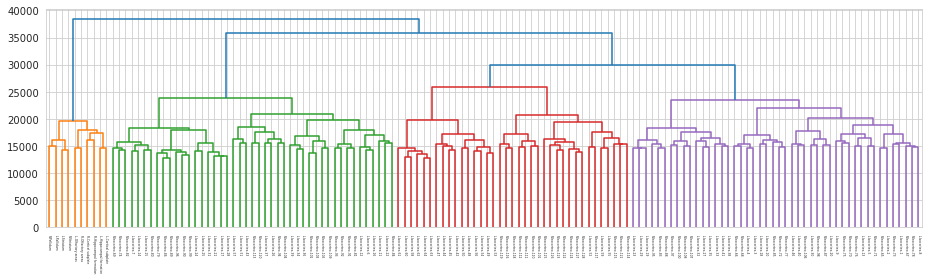

C0,"['(10)', '(45)', '(46)']"
C1,"['(16)', '(21)']"


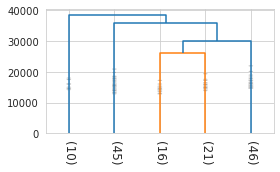

C0,"['(10)', '(46)']"
C1,"['(19)', '(26)']"
C2,"['(16)', '(21)']"


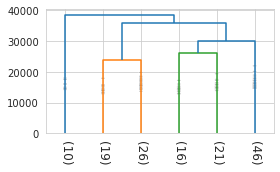

C0,['(10)']
C1,"['(19)', '(26)']"
C2,"['(16)', '(21)']"
C3,"['(16)', '(30)']"


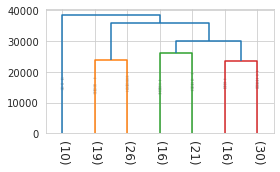






----------------------------------------------------------------------
----------------------------------------------------------------------
			 correlation
----------------------------------------------------------------------
----------------------------------------------------------------------


C1,"['L-Isocortex-1', 'L-Isocortex-8', 'L-Isocortex-12', 'L-Isocortex-16', 'L-Isocortex-19', 'L-Isocortex-23', 'L-Isocortex-27', 'L-Isocortex-29', 'L-Isocortex-33', 'L-Isocortex-38', 'L-Isocortex-40', 'L-Isocortex-41', 'L-Isocortex-46', 'L-Isocortex-48', 'L-Isocortex-49', 'L-Isocortex-50', 'L-Isocortex-52', 'L-Isocortex-53', 'L-Isocortex-54', 'L-Isocortex-55', 'L-Isocortex-56', 'L-Isocortex-58', 'L-Isocortex-59', 'L-Isocortex-60', 'L-Isocortex-61', 'L-Isocortex-62', 'L-Isocortex-63', 'L-Isocortex-64', 'R-Isocortex-67', 'R-Isocortex-73', 'R-Isocortex-78', 'R-Isocortex-83', 'R-Isocortex-88', 'R-Isocortex-95', 'R-Isocortex-97', 'R-Isocortex-100', 'R-Isocortex-106', 'R-Isocortex-107', 'R-Isocortex-108', 'R-Isocortex-114', 'R-Isocortex-115', 'R-Isocortex-116', 'R-Isocortex-117', 'R-Isocortex-118', 'R-Isocortex-119', 'R-Isocortex-121', 'R-Isocortex-122', 'R-Isocortex-123', 'R-Isocortex-124', 'R-Isocortex-125', 'R-Isocortex-126', 'R-Isocortex-127', 'R-Isocortex-128']"
C2,"['L-Isocortex-6', 'L-Isocortex-7', 'L-Isocortex-14', 'L-Isocortex-15', 'L-Isocortex-17', 'L-Isocortex-21', 'L-Isocortex-24', 'L-Isocortex-25', 'L-Isocortex-28', 'L-Isocortex-31', 'L-Isocortex-34', 'L-Isocortex-35', 'L-Isocortex-36', 'L-Isocortex-39', 'L-Isocortex-42', 'L-Isocortex-44', 'L-Isocortex-45', 'L-Isocortex-47', 'R-Isocortex-69', 'R-Isocortex-74', 'R-Isocortex-79', 'R-Isocortex-80', 'R-Isocortex-81', 'R-Isocortex-82', 'R-Isocortex-86', 'R-Isocortex-89', 'R-Isocortex-90', 'R-Isocortex-91', 'R-Isocortex-92', 'R-Isocortex-93', 'R-Isocortex-96', 'R-Isocortex-99', 'R-Isocortex-101', 'R-Isocortex-102', 'R-Isocortex-103', 'R-Isocortex-105', 'R-Isocortex-109', 'R-Isocortex-110', 'R-Isocortex-111', 'R-Isocortex-112']"
C3,"['L-Cortical subplate', 'R-Cortical subplate', 'L-Hippocampal formation', 'R-Hippocampal formation', 'L-Isocortex-2', 'L-Isocortex-3', 'L-Isocortex-4', 'L-Isocortex-5', 'L-Isocortex-9', 'L-Isocortex-10', 'L-Isocortex-11', 'L-Isocortex-13', 'L-Isocortex-18', 'L-Isocortex-20', 'L-Isocortex-22', 'L-Isocortex-26', 'L-Isocortex-30', 'L-Isocortex-32', 'L-Isocortex-37', 'L-Isocortex-43', 'L-Isocortex-51', 'L-Isocortex-57', 'L-Olfactory areas', 'R-Olfactory areas', 'L-Pallidum', 'R-Pallidum', 'R-Isocortex-65', 'R-Isocortex-66', 'R-Isocortex-68', 'R-Isocortex-70', 'R-Isocortex-71', 'R-Isocortex-72', 'R-Isocortex-75', 'R-Isocortex-76', 'R-Isocortex-77', 'R-Isocortex-84', 'R-Isocortex-85', 'R-Isocortex-87', 'R-Isocortex-94', 'R-Isocortex-98', 'R-Isocortex-104', 'R-Isocortex-113', 'R-Isocortex-120', 'L-Striatum', 'R-Striatum']"


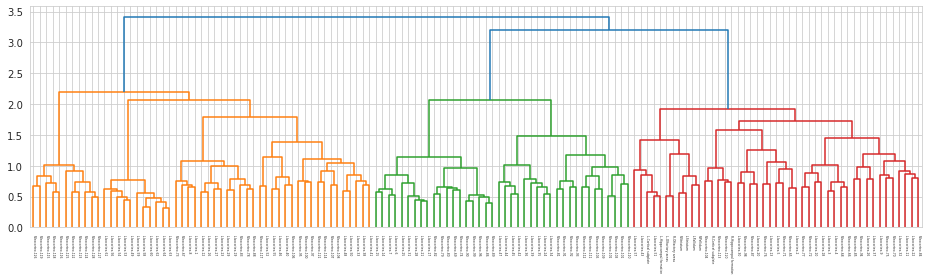

C0,['(45)']
C1,"['(11)', '(42)']"
C2,"['(19)', '(21)']"


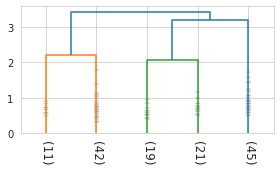

C0,['(45)']
C1,"['(11)', '(11)', '(31)']"
C2,"['(19)', '(21)']"


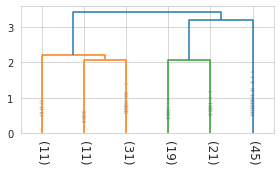

C1,"['(11)', '(11)', '(31)']"
C2,"['(19)', '(21)']"
C3,"['(11)', '(34)']"


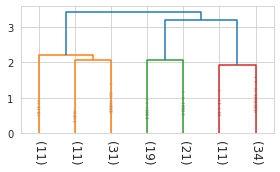






----------------------------------------------------------------------
----------------------------------------------------------------------
			 cosine
----------------------------------------------------------------------
----------------------------------------------------------------------


C1,"['L-Isocortex-1', 'L-Isocortex-8', 'L-Isocortex-12', 'L-Isocortex-16', 'L-Isocortex-19', 'L-Isocortex-23', 'L-Isocortex-27', 'L-Isocortex-29', 'L-Isocortex-33', 'L-Isocortex-38', 'L-Isocortex-40', 'L-Isocortex-41', 'L-Isocortex-46', 'L-Isocortex-48', 'L-Isocortex-49', 'L-Isocortex-50', 'L-Isocortex-52', 'L-Isocortex-53', 'L-Isocortex-54', 'L-Isocortex-55', 'L-Isocortex-56', 'L-Isocortex-58', 'L-Isocortex-59', 'L-Isocortex-60', 'L-Isocortex-61', 'L-Isocortex-62', 'L-Isocortex-63', 'L-Isocortex-64', 'R-Isocortex-67', 'R-Isocortex-73', 'R-Isocortex-78', 'R-Isocortex-83', 'R-Isocortex-88', 'R-Isocortex-95', 'R-Isocortex-97', 'R-Isocortex-100', 'R-Isocortex-106', 'R-Isocortex-107', 'R-Isocortex-108', 'R-Isocortex-114', 'R-Isocortex-115', 'R-Isocortex-116', 'R-Isocortex-117', 'R-Isocortex-118', 'R-Isocortex-119', 'R-Isocortex-121', 'R-Isocortex-122', 'R-Isocortex-123', 'R-Isocortex-124', 'R-Isocortex-125', 'R-Isocortex-126', 'R-Isocortex-127', 'R-Isocortex-128']"
C2,"['L-Isocortex-6', 'L-Isocortex-7', 'L-Isocortex-14', 'L-Isocortex-15', 'L-Isocortex-17', 'L-Isocortex-21', 'L-Isocortex-24', 'L-Isocortex-25', 'L-Isocortex-28', 'L-Isocortex-31', 'L-Isocortex-34', 'L-Isocortex-35', 'L-Isocortex-36', 'L-Isocortex-39', 'L-Isocortex-42', 'L-Isocortex-44', 'L-Isocortex-45', 'L-Isocortex-47', 'R-Isocortex-69', 'R-Isocortex-74', 'R-Isocortex-79', 'R-Isocortex-80', 'R-Isocortex-81', 'R-Isocortex-82', 'R-Isocortex-86', 'R-Isocortex-89', 'R-Isocortex-90', 'R-Isocortex-91', 'R-Isocortex-92', 'R-Isocortex-93', 'R-Isocortex-96', 'R-Isocortex-99', 'R-Isocortex-101', 'R-Isocortex-102', 'R-Isocortex-103', 'R-Isocortex-105', 'R-Isocortex-109', 'R-Isocortex-110', 'R-Isocortex-111', 'R-Isocortex-112']"
C3,"['L-Cortical subplate', 'R-Cortical subplate', 'L-Hippocampal formation', 'R-Hippocampal formation', 'L-Isocortex-2', 'L-Isocortex-3', 'L-Isocortex-4', 'L-Isocortex-5', 'L-Isocortex-9', 'L-Isocortex-10', 'L-Isocortex-11', 'L-Isocortex-13', 'L-Isocortex-18', 'L-Isocortex-20', 'L-Isocortex-22', 'L-Isocortex-26', 'L-Isocortex-30', 'L-Isocortex-32', 'L-Isocortex-37', 'L-Isocortex-43', 'L-Isocortex-51', 'L-Isocortex-57', 'L-Olfactory areas', 'R-Olfactory areas', 'L-Pallidum', 'R-Pallidum', 'R-Isocortex-65', 'R-Isocortex-66', 'R-Isocortex-68', 'R-Isocortex-70', 'R-Isocortex-71', 'R-Isocortex-72', 'R-Isocortex-75', 'R-Isocortex-76', 'R-Isocortex-77', 'R-Isocortex-84', 'R-Isocortex-85', 'R-Isocortex-87', 'R-Isocortex-94', 'R-Isocortex-98', 'R-Isocortex-104', 'R-Isocortex-113', 'R-Isocortex-120', 'L-Striatum', 'R-Striatum']"


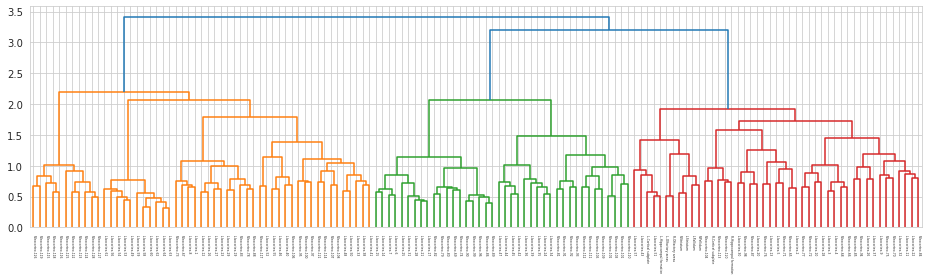

C0,['(45)']
C1,"['(11)', '(42)']"
C2,"['(19)', '(21)']"


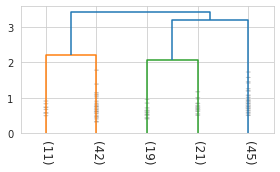

C0,['(45)']
C1,"['(11)', '(11)', '(31)']"
C2,"['(19)', '(21)']"


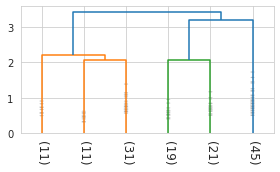

C1,"['(11)', '(11)', '(31)']"
C2,"['(19)', '(21)']"
C3,"['(11)', '(34)']"


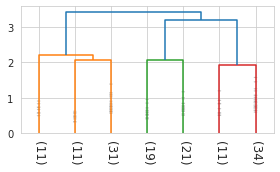






----------------------------------------------------------------------
----------------------------------------------------------------------
			 euclidean
----------------------------------------------------------------------
----------------------------------------------------------------------


C1,"['L-Isocortex-49', 'L-Isocortex-53', 'L-Isocortex-54', 'L-Isocortex-56', 'L-Isocortex-58', 'L-Isocortex-59', 'L-Isocortex-60', 'L-Isocortex-61', 'L-Isocortex-62', 'L-Isocortex-63', 'L-Isocortex-64']"
C2,"['L-Isocortex-6', 'L-Isocortex-7', 'L-Isocortex-14', 'L-Isocortex-15', 'L-Isocortex-17', 'L-Isocortex-21', 'L-Isocortex-28', 'L-Isocortex-31', 'R-Isocortex-69', 'R-Isocortex-74', 'R-Isocortex-79', 'R-Isocortex-80', 'R-Isocortex-81', 'R-Isocortex-82', 'R-Isocortex-86', 'R-Isocortex-89', 'R-Isocortex-90', 'R-Isocortex-91', 'R-Isocortex-96', 'R-Isocortex-99']"
C3,"['R-Isocortex-116', 'R-Isocortex-118', 'R-Isocortex-119', 'R-Isocortex-121', 'R-Isocortex-122', 'R-Isocortex-123', 'R-Isocortex-124', 'R-Isocortex-126', 'R-Isocortex-127', 'R-Isocortex-128']"
C4,"['L-Cortical subplate', 'R-Cortical subplate', 'L-Hippocampal formation', 'R-Hippocampal formation', 'L-Isocortex-1', 'L-Isocortex-2', 'L-Isocortex-3', 'L-Isocortex-4', 'L-Isocortex-5', 'L-Isocortex-8', 'L-Isocortex-9', 'L-Isocortex-10', 'L-Isocortex-11', 'L-Isocortex-12', 'L-Isocortex-13', 'L-Isocortex-16', 'L-Isocortex-18', 'L-Isocortex-19', 'L-Isocortex-20', 'L-Isocortex-22', 'L-Isocortex-23', 'L-Isocortex-24', 'L-Isocortex-25', 'L-Isocortex-26', 'L-Isocortex-27', 'L-Isocortex-29', 'L-Isocortex-30', 'L-Isocortex-32', 'L-Isocortex-33', 'L-Isocortex-34', 'L-Isocortex-35', 'L-Isocortex-36', 'L-Isocortex-37', 'L-Isocortex-38', 'L-Isocortex-39', 'L-Isocortex-40', 'L-Isocortex-41', 'L-Isocortex-42', 'L-Isocortex-43', 'L-Isocortex-44', 'L-Isocortex-45', 'L-Isocortex-46', 'L-Isocortex-47', 'L-Isocortex-48', 'L-Isocortex-50', 'L-Isocortex-51', 'L-Isocortex-52', 'L-Isocortex-55', 'L-Isocortex-57', 'L-Olfactory areas', 'R-Olfactory areas', 'L-Pallidum', 'R-Pallidum', 'R-Isocortex-65', 'R-Isocortex-66', 'R-Isocortex-67', 'R-Isocortex-68', 'R-Isocortex-70', 'R-Isocortex-71', 'R-Isocortex-72', 'R-Isocortex-73', 'R-Isocortex-75', 'R-Isocortex-76', 'R-Isocortex-77', 'R-Isocortex-78', 'R-Isocortex-83', 'R-Isocortex-84', 'R-Isocortex-85', 'R-Isocortex-87', 'R-Isocortex-88', 'R-Isocortex-92', 'R-Isocortex-93', 'R-Isocortex-94', 'R-Isocortex-95', 'R-Isocortex-97', 'R-Isocortex-98', 'R-Isocortex-100', 'R-Isocortex-101', 'R-Isocortex-102', 'R-Isocortex-103', 'R-Isocortex-104', 'R-Isocortex-105', 'R-Isocortex-106', 'R-Isocortex-107', 'R-Isocortex-108', 'R-Isocortex-109', 'R-Isocortex-110', 'R-Isocortex-111', 'R-Isocortex-112', 'R-Isocortex-113', 'R-Isocortex-114', 'R-Isocortex-115', 'R-Isocortex-117', 'R-Isocortex-120', 'R-Isocortex-125', 'L-Striatum', 'R-Striatum']"


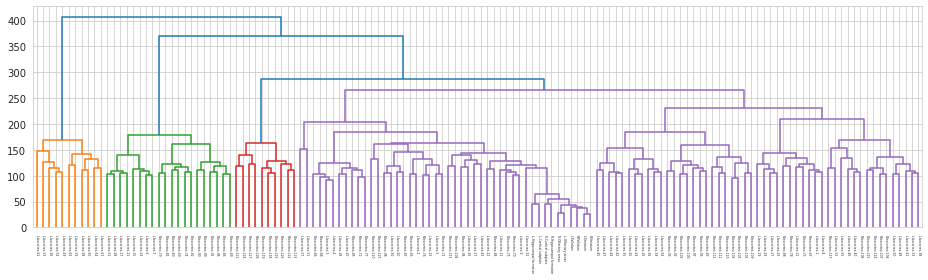

C0,"['(11)', '(20)', '(10)']"
C1,"['(46)', '(51)']"


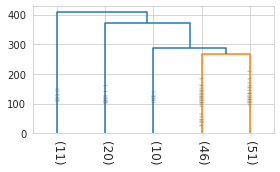

C0,"['(11)', '(20)', '(10)']"
C1,"['(46)', '(25)', '(26)']"


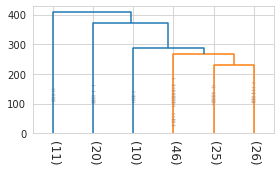

C0,"['(11)', '(20)', '(10)']"
C1,"['(46)', '(25)', '(11)', '(15)']"


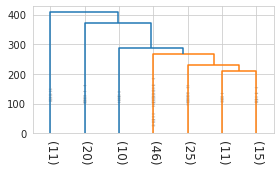






----------------------------------------------------------------------
----------------------------------------------------------------------
			 seuclidean
----------------------------------------------------------------------
----------------------------------------------------------------------


C1,"['L-Isocortex-6', 'L-Isocortex-7', 'L-Isocortex-14', 'L-Isocortex-15', 'L-Isocortex-16', 'L-Isocortex-17', 'L-Isocortex-21', 'L-Isocortex-24', 'L-Isocortex-25', 'L-Isocortex-28', 'L-Isocortex-31', 'R-Isocortex-69', 'R-Isocortex-74', 'R-Isocortex-79', 'R-Isocortex-80', 'R-Isocortex-81', 'R-Isocortex-82', 'R-Isocortex-86', 'R-Isocortex-89', 'R-Isocortex-90', 'R-Isocortex-91', 'R-Isocortex-96', 'R-Isocortex-99']"
C2,"['L-Isocortex-53', 'L-Isocortex-58', 'L-Isocortex-59', 'L-Isocortex-60', 'L-Isocortex-61', 'L-Isocortex-62', 'L-Isocortex-63', 'L-Isocortex-64']"
C3,"['L-Cortical subplate', 'R-Cortical subplate', 'L-Hippocampal formation', 'R-Hippocampal formation', 'L-Isocortex-2', 'L-Isocortex-3', 'L-Isocortex-4', 'L-Isocortex-5', 'L-Isocortex-9', 'L-Isocortex-10', 'L-Isocortex-11', 'L-Isocortex-13', 'L-Isocortex-18', 'L-Isocortex-20', 'L-Isocortex-22', 'L-Isocortex-26', 'L-Isocortex-30', 'L-Isocortex-32', 'L-Isocortex-37', 'L-Isocortex-43', 'L-Isocortex-51', 'L-Isocortex-57', 'L-Olfactory areas', 'R-Olfactory areas', 'L-Pallidum', 'R-Pallidum', 'R-Isocortex-65', 'R-Isocortex-66', 'R-Isocortex-68', 'R-Isocortex-70', 'R-Isocortex-71', 'R-Isocortex-72', 'R-Isocortex-75', 'R-Isocortex-76', 'R-Isocortex-77', 'R-Isocortex-84', 'R-Isocortex-85', 'R-Isocortex-87', 'R-Isocortex-94', 'R-Isocortex-98', 'R-Isocortex-104', 'R-Isocortex-113', 'R-Isocortex-120', 'R-Isocortex-125', 'L-Striatum', 'R-Striatum']"
C4,"['L-Isocortex-1', 'L-Isocortex-8', 'L-Isocortex-12', 'L-Isocortex-19', 'L-Isocortex-23', 'L-Isocortex-27', 'L-Isocortex-29', 'L-Isocortex-33', 'L-Isocortex-34', 'L-Isocortex-35', 'L-Isocortex-36', 'L-Isocortex-38', 'L-Isocortex-39', 'L-Isocortex-40', 'L-Isocortex-41', 'L-Isocortex-42', 'L-Isocortex-44', 'L-Isocortex-45', 'L-Isocortex-46', 'L-Isocortex-47', 'L-Isocortex-48', 'L-Isocortex-49', 'L-Isocortex-50', 'L-Isocortex-52', 'L-Isocortex-54', 'L-Isocortex-55', 'L-Isocortex-56', 'R-Isocortex-67', 'R-Isocortex-73', 'R-Isocortex-78', 'R-Isocortex-83', 'R-Isocortex-88', 'R-Isocortex-92', 'R-Isocortex-93', 'R-Isocortex-95', 'R-Isocortex-97', 'R-Isocortex-100', 'R-Isocortex-101', 'R-Isocortex-102', 'R-Isocortex-103', 'R-Isocortex-105', 'R-Isocortex-106', 'R-Isocortex-107', 'R-Isocortex-108', 'R-Isocortex-109', 'R-Isocortex-110', 'R-Isocortex-111', 'R-Isocortex-112', 'R-Isocortex-114', 'R-Isocortex-115', 'R-Isocortex-116', 'R-Isocortex-117', 'R-Isocortex-118', 'R-Isocortex-119', 'R-Isocortex-121', 'R-Isocortex-122', 'R-Isocortex-123', 'R-Isocortex-124', 'R-Isocortex-126', 'R-Isocortex-127', 'R-Isocortex-128']"


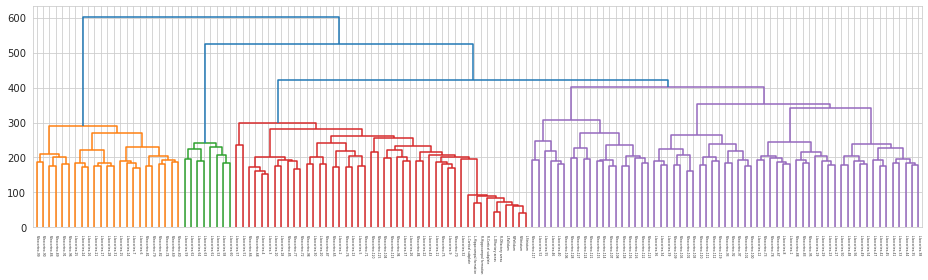

C0,"['(23)', '(8)', '(46)']"
C1,"['(19)', '(42)']"


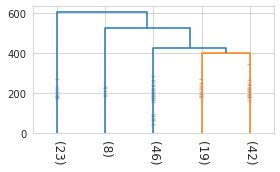

C0,"['(23)', '(8)', '(46)']"
C1,"['(19)', '(16)', '(26)']"


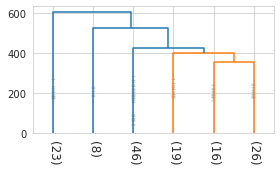

C0,"['(23)', '(8)', '(46)']"
C1,"['(19)', '(16)', '(13)', '(13)']"


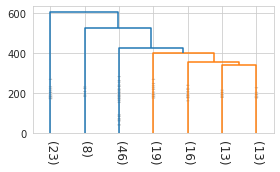

...merging dicts: 0it [00:00, ?it/s]

In [23]:
dict_list = []
for metric in metrics:
    if metric in skip:
        continue
    
    print('-' * 70)
    print('-' * 70)
    print('\t\t\t', metric)
    print('-' * 70)
    print('-' * 70)
    
    results = hierarchical_cluster(
        df=df_combined,
        method='ward',
        dist_metric=metric,
        link_metric=metric,
    )
    labels = translate_labels(results['labels'], allen['mcc'])
    
    # full
    output = get_clust_graph(
        linkage_mat=results['z'],
        labels=labels,
        num_clusters=0,
        leaf_font_size=3,
        orientation='top',
        figsize=(13, 4),
    )
    n_clusters = len(output['cluster_assigns'])
    display(output['cluster_classes'])
    display(output['fig'])

    quality_list = []
    for idx, cluster_list in output['cluster_assigns'].items():
        lr_ctr = collections.Counter([x.split('-')[0] for x in cluster_list])
        quality = 1 - np.abs(lr_ctr['L'] - lr_ctr['R']) / len(cluster_list)
        quality_list.append(quality)
    data_dict = {
        'n_clusters': [n_clusters] * len(quality_list),
        'tag': ['full'] * len(quality_list),
        'metric': [metric] * len(quality_list),
        'quality': quality_list,
    }
    dict_list.append(data_dict)
    print()
    
    # 5 clusters
    output = get_clust_graph(
        linkage_mat=results['z'],
        labels=labels,
        num_clusters=5,
        leaf_font_size=12,
        figsize=(4, 2.5),
    )
    n_clusters = len(output['cluster_assigns'])
    display(output['cluster_classes'])
    display(output['fig'])

    quality_list = []
    for idx, cluster_list in output['cluster_assigns'].items():
        lr_ctr = collections.Counter([x.split('-')[0] for x in cluster_list])
        quality = 1 - np.abs(lr_ctr['L'] - lr_ctr['R']) / len(cluster_list)
        quality_list.append(quality)
    data_dict = {
        'n_clusters': [n_clusters] * len(quality_list),
        'tag': ['5 clusters'] * len(quality_list),
        'metric': [metric] * len(quality_list),
        'quality': quality_list,
    }
    dict_list.append(data_dict)
    print()
    
    # 6 clusters
    output = get_clust_graph(
        linkage_mat=results['z'],
        labels=labels,
        num_clusters=6,
        leaf_font_size=12,
        figsize=(4, 2.5),
    )
    n_clusters = len(output['cluster_assigns'])
    display(output['cluster_classes'])
    display(output['fig'])

    quality_list = []
    for idx, cluster_list in output['cluster_assigns'].items():
        lr_ctr = collections.Counter([x.split('-')[0] for x in cluster_list])
        quality = 1 - np.abs(lr_ctr['L'] - lr_ctr['R']) / len(cluster_list)
        quality_list.append(quality)
    data_dict = {
        'n_clusters': [n_clusters] * len(quality_list),
        'tag': ['6 clusters'] * len(quality_list),
        'metric': [metric] * len(quality_list),
        'quality': quality_list,
    }
    dict_list.append(data_dict)
    print()
    
    # 7 clusters
    output = get_clust_graph(
        linkage_mat=results['z'],
        labels=labels,
        num_clusters=7,
        leaf_font_size=12,
        figsize=(4, 2.5),
    )
    n_clusters = len(output['cluster_assigns'])
    display(output['cluster_classes'])
    display(output['fig'])

    quality_list = []
    for idx, cluster_list in output['cluster_assigns'].items():
        lr_ctr = collections.Counter([x.split('-')[0] for x in cluster_list])
        quality = 1 - np.abs(lr_ctr['L'] - lr_ctr['R']) / len(cluster_list)
        quality_list.append(quality)
    data_dict = {
        'n_clusters': [n_clusters] * len(quality_list),
        'tag': ['7 clusters'] * len(quality_list),
        'metric': [metric] * len(quality_list),
        'quality': quality_list,
    }
    dict_list.append(data_dict)
    print('\n\n\n\n')

quality_df = pd.DataFrame(merge_dicts(dict_list))

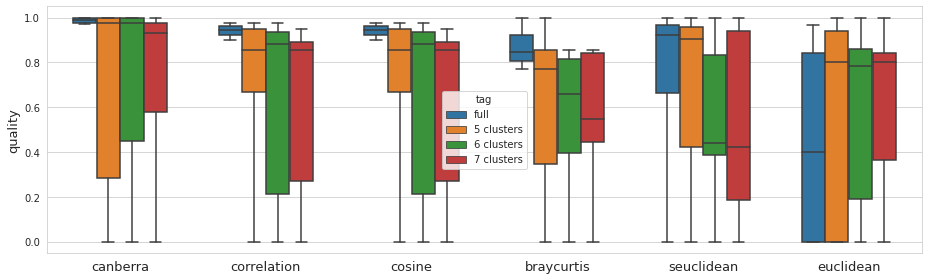

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(13, 4))

order = {k: quality_df.loc[quality_df.metric == k, 'quality'].mean() for k in quality_df.metric.unique()}
order = dict(sorted(order.items(), key=lambda x: x[1], reverse=True))

sns.boxplot(
    data=quality_df,
    x='metric',
    y='quality',
    hue='tag',
    order=order,
    width=0.65,
    saturation=0.75,
    whis=10,
    ax=ax,
)
ax.tick_params(axis='x', rotation=0, labelsize=13)
ax.set_xlabel('')
ax.set_ylabel(ax.get_ylabel(), fontsize=13)
fig.tight_layout()
plt.show()

## Results: using canberra

In [25]:
results = hierarchical_cluster(
    df=df_combined,
    method='ward',
    dist_metric='canberra',
    link_metric='canberra',
)
labels = translate_labels(results['labels'], allen['mcc'])

### full (canberra gives 4 clusters)

C1,"['L-Cortical subplate', 'R-Cortical subplate', 'L-Hippocampal formation', 'R-Hippocampal formation', 'L-Olfactory areas', 'R-Olfactory areas', 'L-Pallidum', 'R-Pallidum', 'L-Striatum', 'R-Striatum']"
C2,"['L-Isocortex-6', 'L-Isocortex-7', 'L-Isocortex-11', 'L-Isocortex-12', 'L-Isocortex-14', 'L-Isocortex-15', 'L-Isocortex-16', 'L-Isocortex-17', 'L-Isocortex-21', 'L-Isocortex-22', 'L-Isocortex-24', 'L-Isocortex-25', 'L-Isocortex-26', 'L-Isocortex-28', 'L-Isocortex-31', 'L-Isocortex-34', 'L-Isocortex-36', 'L-Isocortex-37', 'L-Isocortex-39', 'L-Isocortex-43', 'L-Isocortex-51', 'L-Isocortex-57', 'R-Isocortex-69', 'R-Isocortex-74', 'R-Isocortex-79', 'R-Isocortex-80', 'R-Isocortex-81', 'R-Isocortex-82', 'R-Isocortex-84', 'R-Isocortex-86', 'R-Isocortex-89', 'R-Isocortex-90', 'R-Isocortex-91', 'R-Isocortex-92', 'R-Isocortex-93', 'R-Isocortex-94', 'R-Isocortex-96', 'R-Isocortex-99', 'R-Isocortex-102', 'R-Isocortex-103', 'R-Isocortex-104', 'R-Isocortex-105', 'R-Isocortex-109', 'R-Isocortex-113', 'R-Isocortex-120']"
C3,"['L-Isocortex-42', 'L-Isocortex-44', 'L-Isocortex-45', 'L-Isocortex-47', 'L-Isocortex-48', 'L-Isocortex-49', 'L-Isocortex-50', 'L-Isocortex-52', 'L-Isocortex-53', 'L-Isocortex-54', 'L-Isocortex-55', 'L-Isocortex-56', 'L-Isocortex-58', 'L-Isocortex-59', 'L-Isocortex-60', 'L-Isocortex-61', 'L-Isocortex-62', 'L-Isocortex-63', 'L-Isocortex-64', 'R-Isocortex-101', 'R-Isocortex-110', 'R-Isocortex-111', 'R-Isocortex-112', 'R-Isocortex-114', 'R-Isocortex-115', 'R-Isocortex-116', 'R-Isocortex-117', 'R-Isocortex-118', 'R-Isocortex-119', 'R-Isocortex-121', 'R-Isocortex-122', 'R-Isocortex-123', 'R-Isocortex-124', 'R-Isocortex-125', 'R-Isocortex-126', 'R-Isocortex-127', 'R-Isocortex-128']"
C4,"['L-Isocortex-1', 'L-Isocortex-2', 'L-Isocortex-3', 'L-Isocortex-4', 'L-Isocortex-5', 'L-Isocortex-8', 'L-Isocortex-9', 'L-Isocortex-10', 'L-Isocortex-13', 'L-Isocortex-18', 'L-Isocortex-19', 'L-Isocortex-20', 'L-Isocortex-23', 'L-Isocortex-27', 'L-Isocortex-29', 'L-Isocortex-30', 'L-Isocortex-32', 'L-Isocortex-33', 'L-Isocortex-35', 'L-Isocortex-38', 'L-Isocortex-40', 'L-Isocortex-41', 'L-Isocortex-46', 'R-Isocortex-65', 'R-Isocortex-66', 'R-Isocortex-67', 'R-Isocortex-68', 'R-Isocortex-70', 'R-Isocortex-71', 'R-Isocortex-72', 'R-Isocortex-73', 'R-Isocortex-75', 'R-Isocortex-76', 'R-Isocortex-77', 'R-Isocortex-78', 'R-Isocortex-83', 'R-Isocortex-85', 'R-Isocortex-87', 'R-Isocortex-88', 'R-Isocortex-95', 'R-Isocortex-97', 'R-Isocortex-98', 'R-Isocortex-100', 'R-Isocortex-106', 'R-Isocortex-107', 'R-Isocortex-108']"


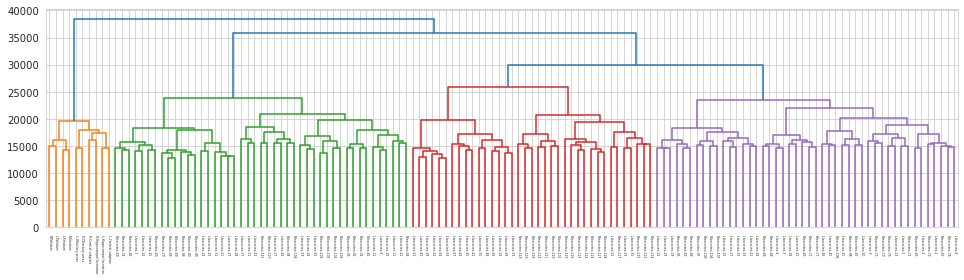

In [26]:
output = get_clust_graph(
    linkage_mat=results['z'],
    labels=labels,
    num_clusters=0,
    leaf_font_size=3,
    orientation='top',
    figsize=(13.5, 4),
)
display(output['cluster_classes'])
display(output['fig'])

In [27]:
community = {
    i: translate_labels(leaves, allen['mcc'], forward=False)
    for i, leaves in output['cluster_assigns'].items()
}

comms3d = np.zeros(allen['template'].shape)
for cluster_idx, leaves in community.items():
    for lbl in leaves:
        if str(allen['isocortex']['id']) in lbl:
            lr, structure_id, region_id = tuple(map(lambda x: int(x), lbl.split('-')))
            comms3d[parcellation['atlas_kmeans'] == region_id] = cluster_idx
        else:
            comms3d[roi_masks[lbl]] = cluster_idx

In [28]:
fixed = reset_ants_img(allen['template'])

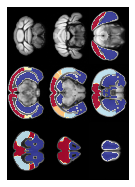

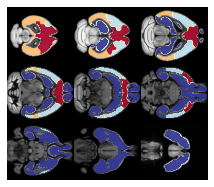

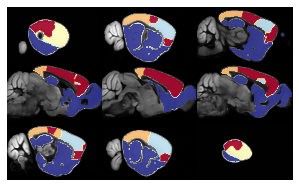

In [29]:
x = comms3d.copy()
x[~allen['cerebrum_mask'].astype(bool)] = np.nan

for axis in range(3):
    fixed.plot(
        overlay=ants.from_numpy(x),
        overlay_cmap='RdYlBu_r',
        overlay_alpha=0.9,
        nslices=9,
        figsize=0.8,
        axis=axis,
    )

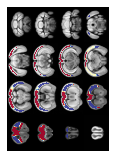

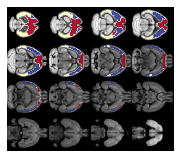

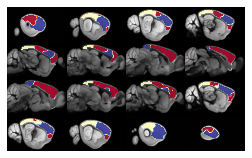

In [30]:
x = comms3d.copy()
x[~allen['isocortex_mask'].astype(bool)] = np.nan

for axis in range(3):
    fixed.plot(
        overlay=ants.from_numpy(x),
        overlay_cmap='RdYlBu_r',
        overlay_alpha=0.9,
        nslices=16,
        figsize=0.5,
        axis=axis,
    )

### Save results to render

In [31]:
tab20c = sns.color_palette('tab20c', n_colors=20)
tab20c

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
 (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
 (0.7764705882352941, 0.8588235294117647, 0.9372549019607843),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.9921568627450981, 0.8156862745098039, 0.6352941176470588),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157),
 (0.8549019607843137, 0.8549019607843137, 0.9215686274509803),
 (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
 (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
 (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627)]

In [32]:
cluster_color_idxs = {
    2: [0, 16],
    3: [0, 4, 12], 
    4: [0, 8, 4, 12],
    5: [0, 8, 4, 6, 12],
    6: [0, 8, 10, 4, 6, 12],
    7: [0, 8, 10, 4, 6, 12, 14],
    8: [0, 8, 10, 4, 6, 12, 14, 15],
    9: [0, 8, 10, 11, 4, 6, 12, 14, 15],
    10: [0, 8, 10, 11, 4, 6, 7, 12, 14, 15],
    11: [0, 8, 10, 11, 4, 6, 7, 12, 13, 14, 15],
    12: [0, 8, 9, 10, 11, 4, 6, 7, 12, 13, 14, 15],
    13: [0, 8, 9, 10, 11, 4, 5, 6, 7, 12, 13, 14, 15],
    14: [0, 2, 8, 9, 10, 11, 4, 5, 6, 7, 12, 13, 14, 15],
}

n_clusters = 2


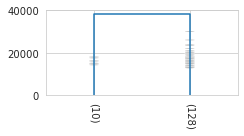

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.38823529411764707, 0.38823529411764707, 0.38823529411764707)]




n_clusters = 3


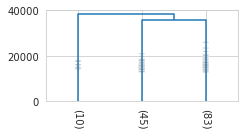

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235)]




n_clusters = 4


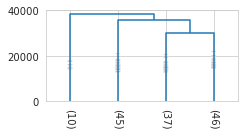

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235)]




n_clusters = 5


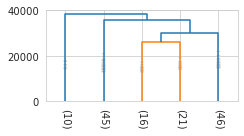

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235)]




n_clusters = 6


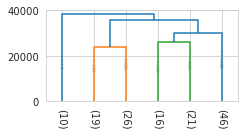

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235)]




n_clusters = 7


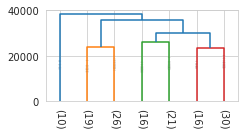

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157)]




n_clusters = 8


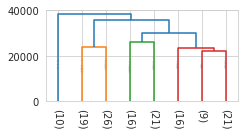

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157),
 (0.8549019607843137, 0.8549019607843137, 0.9215686274509803)]




n_clusters = 9


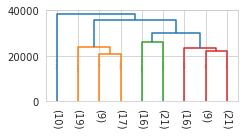

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157),
 (0.8549019607843137, 0.8549019607843137, 0.9215686274509803)]




n_clusters = 10


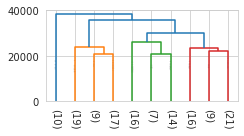

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.9921568627450981, 0.8156862745098039, 0.6352941176470588),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157),
 (0.8549019607843137, 0.8549019607843137, 0.9215686274509803)]




n_clusters = 11


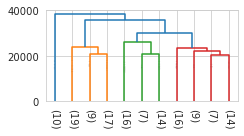

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.9921568627450981, 0.8156862745098039, 0.6352941176470588),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157),
 (0.8549019607843137, 0.8549019607843137, 0.9215686274509803)]




n_clusters = 12


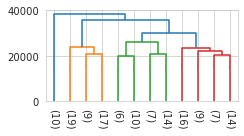

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.9921568627450981, 0.8156862745098039, 0.6352941176470588),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157),
 (0.8549019607843137, 0.8549019607843137, 0.9215686274509803)]




n_clusters = 13


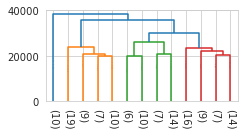

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.9921568627450981, 0.8156862745098039, 0.6352941176470588),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157),
 (0.8549019607843137, 0.8549019607843137, 0.9215686274509803)]




n_clusters = 14


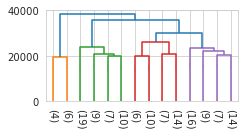

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.9921568627450981, 0.8156862745098039, 0.6352941176470588),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157),
 (0.8549019607843137, 0.8549019607843137, 0.9215686274509803)]

In [33]:
colors_all = {}
comm3d_all = {}

for n_clusters in range(2, 15):
    palette = sns.color_palette(np.array(tab20c)[cluster_color_idxs[n_clusters]])
    colors_all[n_clusters] = list(palette)
    
    output = get_clust_graph(
        linkage_mat=results['z'],
        labels=labels,
        num_clusters=n_clusters,
        leaf_font_size=10,
        figsize=(3.5, 2),
    )
    print(f"n_clusters = {n_clusters}")
    display(output['fig'])
    display(palette)
    print('\n\n')
    
    community = {
        i: translate_labels(leaves, allen['mcc'], forward=False)
        for i, leaves in output['cluster_assigns'].items()
    }
    assert len(community) == n_clusters

    comms3d = np.zeros(allen['template'].shape)
    for cluster_idx, leaves in community.items():
        for lbl in leaves:
            if str(allen['isocortex']['id']) in lbl:
                lr, structure_id, region_id = tuple(map(lambda x: int(x), lbl.split('-')))
                comms3d[parcellation['atlas_kmeans'] == region_id] = cluster_idx
            else:
                comms3d[roi_masks[lbl]] = cluster_idx
    comm3d_all[n_clusters] = comms3d

## Render

In [34]:
import os
import sys
import numpy as np
from matplotlib.colors import rgb2hex
from os.path import join as pjoin

from rich import print
from myterial import orange, blue_grey
from pathlib import Path

from bg_space import AnatomicalSpace

In [35]:
br_path = pjoin(os.environ['HOME'], 'Dropbox/git/brainrender/')
vedo_path = pjoin(os.environ['HOME'], 'Dropbox/git/vedo/')
sys.path.insert(0, br_path)
sys.path.insert(0, vedo_path)

import brainrender
from brainrender import Scene, settings

import vedo
from vedo import settings as vsettings
from vedo import Volume, merge

/home/hadi/anaconda3/lib/python3.8/site-packages/neurom/fst/__init__.py:8: DeprecationWarning:

neurom.fst is being deprecated and will be removed in NeuroM v1.5.0, replace it by neurom.features

<frozen importlib._bootstrap>:219: RuntimeWarning:

numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject



In [36]:
print(brainrender.__file__)
print(vedo.__file__)

/home/hadi/Dropbox/git/brainrender/brainrender/__init__.py

/home/hadi/Dropbox/git/vedo/vedo/__init__.py

In [37]:
from bg_atlasapi.bg_atlas import BrainGlobeAtlas
atlas = BrainGlobeAtlas("allen_mouse_100um")

source_space = AnatomicalSpace("rsa")
target_space = atlas.space

allen mouse atlas (res. 100um)
From: http://www.brain-map.org (Wang et al 2020, https://doi.org/10.1016/j.cell.2020.04.007 )


In [38]:
for n_clusters, comm3d in comm3d_all.items():
    colors = colors_all[n_clusters]
    
    settings.RENDER = False
    scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)

    surfaces = []
    names = []
    for cluster_i, c in zip(range(1, n_clusters+1), colors):
        x = (comm3d == cluster_i)
        x = source_space.map_stack_to(target_space, x)

        vol = Volume(x.astype('uint8'), spacing=[100]*3).medianSmooth()
        surf = vol.isosurface().alpha(1.0).lw(0).c(rgb2hex(c))
        surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
        surfaces.append(surf)
        names.append('Cluster_{:d}'.format(cluster_i))
        
    scene.add(*surfaces, names=names, colors=colors)
    scene.add_silhouette(*scene.actors, lw=0.7, color='k')
    
    settings.RENDER = True
    path = scene.export(f"./_extras/comms3d_64_canberra{n_clusters}.html")
    scene.plotter.close()

Scene saved at _extras/comms3d_64_canberra2.html

Scene saved at _extras/comms3d_64_canberra3.html

Scene saved at _extras/comms3d_64_canberra4.html

Scene saved at _extras/comms3d_64_canberra5.html

Scene saved at _extras/comms3d_64_canberra6.html

Scene saved at _extras/comms3d_64_canberra7.html

Scene saved at _extras/comms3d_64_canberra8.html

Scene saved at _extras/comms3d_64_canberra9.html

Scene saved at _extras/comms3d_64_canberra10.html

Scene saved at _extras/comms3d_64_canberra11.html

Scene saved at _extras/comms3d_64_canberra12.html

Scene saved at _extras/comms3d_64_canberra13.html

Scene saved at _extras/comms3d_64_canberra14.html

### Embed results

In [35]:
from IPython.display import IFrame

for n_clusters in [2, 3, 4, 7, 11, 14]:
    path = f"../../_extras/comms3d_64_canberra{n_clusters}.html"
    
    print(f"num clusters: {n_clusters}")
    display(IFrame(path, width=1000, height=700))
    print('\n\n\n\n')

num clusters: 2







num clusters: 3







num clusters: 4







num clusters: 7







num clusters: 11







num clusters: 14


---
##  Ignore (debugging)
---

In [7]:
import os
import sys
import numpy as np
from matplotlib.colors import rgb2hex
from os.path import join as pjoin

In [8]:
br_path = pjoin(os.environ['HOME'], 'Dropbox/git/brainrender/')
sys.path.insert(0, br_path)

import brainrender
from brainrender import Scene, settings

In [9]:
print(brainrender.__file__)
print(settings.__file__)

/home/hadi/Dropbox/git/brainrender/brainrender/__init__.py

/home/hadi/Dropbox/git/brainrender/brainrender/settings.py

In [10]:
scene = Scene()

In [6]:
scene.atlas.root

╭──────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                      │
│   brainrender.Actor:                                                                 │
│   ──────────────────────                                                             │
│                                                                                      │
│   name: root                                                                         │
│   type: brain region                                                                 │
│   ────────────────────────────────────────────────────────────────────────────────   │
│   center of mass: [7829 4296 5694]                                                   │
│   number of vertices: 49324                                                          │
│   dimensions: [  -16 13192   133  7564   485 10890]                                  │
│   color: [0.8 0.8 0.8]                                                               │
│                                                                                      │
╰──────────────────────────────────────────────────────────────────────────────────────╯

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from vedo import Volume
from vedo import Plotter
from vedo import settings as vsettings

In [2]:
import struct
import string
from matplotlib.colors import rgb2hex, to_rgb


def rgb2int(color):
    r, g, b = to_rgb(color)
    rgb_packed = int(0xFFFF * r + 0xFF * g + b)
    return rgb_packed


def is_hex(s):
    return '#' in s and all(c in string.hexdigits for c in s.lstrip('#'))


def unpack_rgb(color):
    color = rgb2hex(color) if not is_hex(color) else color
    rgb_tuple = struct.unpack('BBB', bytes.fromhex(color.lstrip('#')))
    return rgb_tuple


def int2rgb(rgb_int: int):
    r = (rgb_int >> 16) & 255
    g = (rgb_int >> 8) & 255
    b = rgb_int & 255
    return r, g, b


def rgb2int(rgb: tuple):
    def _convert2int(rgb):
        return map(lambda x: int(x * 255) if 0<=x<=1 else int(x), rgb)
    r, g, b = _convert2int(rgb)
    return (r<<16) + (g<<8) + b

In [3]:
x1 = np.zeros([100, 100, 100], dtype=np.uint8)
x2 = np.zeros([100, 100, 100], dtype=np.uint8)
x3 = np.zeros([100, 100, 100], dtype=np.uint8)
x1[10:45,   10:45,  10:45] = 1
x2[45:55, 45:55, 45:55] = 2
x3[55:85, 55:85, 55:85] = 3

In [4]:
surfsaces = [Volume(x).isosurface().color(to_rgb(c)).alpha(1)
             for c, x in zip(['C6', 'C2', 'C8'], [x1, x2, x3])]

vedo_plt = Plotter()
vedo_plt.add(surfsaces, render=False)

type(vedo_plt)

vedo.plotter.Plotter

In [5]:
vedo_plt.addInset(render=False)

(vtkmodules.vtkInteractionWidgets.vtkOrientationMarkerWidget)0x7f955ac46280

In [6]:
import os
import sys
from os.path import join as pjoin

br_path = pjoin(os.environ['HOME'], 'Dropbox/git/brainrender/')
vedo_path = pjoin(os.environ['HOME'], 'Dropbox/git/vedo/')
sys.path.insert(0, br_path)
sys.path.insert(0, vedo_path)

In [9]:
vedo_path

'/home/hadi/Dropbox/git/vedo/'

In [10]:
import brainrender
import vedo

In [11]:
vedo.__file__

'/home/hadi/anaconda3/lib/python3.8/site-packages/vedo/__init__.py'

In [12]:
vsettings.notebookBackend = 'k3d'
k3d_plt = vedo_plt.show(interactive=False)
type(vedo_plt), type(k3d_plt)

(<class 'vedo.plotter.Plotter'>, <class 'k3d.plot.Plot'>)

In [13]:
vp = vsettings.plotter_instance

In [14]:
ia = vedo_plt.actors[0]
iap = ia.GetProperty()

iapoly = ia.clone().clean().triangulate().computeNormals().polydata()

In [15]:
ia.mapper().GetScalarVisibility()

0

In [16]:
vtkdata = iapoly.GetPointData()
vtkscals = vtkdata.GetScalars()

In [17]:
vtkscals

(vtkmodules.vtkCommonCore.vtkFloatArray)0x7f9555f323a0

In [18]:
rgb = to_rgb('C5')
rgb

(0.5490196078431373, 0.33725490196078434, 0.29411764705882354)

In [19]:
rgb_int = rgb2int(rgb)
rgb_int

9197131

In [20]:
int2rgb(rgb_int)

(140, 86, 75)

In [21]:
iap.GetColor()

(0.8901960784313725, 0.4666666666666667, 0.7607843137254902)

In [22]:
iap.GetOpacity()

1.0

In [23]:
rgb2int(iap.GetColor())

14907330

In [24]:
iap.GetInterpolation()

2

In [25]:
import k3d

name = None
kobj = k3d.vtk_poly_data(iapoly,
                         name=name,
                         color=rgb2int(iap.GetColor()),
                         # color_attribute=color_attribute,
                         # color_map=kcmap,
                         opacity=iap.GetOpacity(),
                         wireframe=(iap.GetRepresentation()==1))

In [28]:
kobj.flat_shading

False

In [29]:
vars(kobj)

{
    '_trait_values': {
        'id': 140279370914256,
        'comm': <ipykernel.comm.comm.Comm object at 0x7f95b46f3d60>,
        'vertices': array([[10.      , 10.      ,  9.333333],
       [10.      ,  9.333333, 10.      ],
       [ 9.333333, 10.      , 10.      ],
       ...,
       [42.      , 44.      , 44.666668],
       [43.      , 44.      , 44.666668],
       [44.      , 44.      , 44.666668]], dtype=float32),
        'indices': array([[   0,    1,    2],
       [   0,    3,    4],
       [   1,    0,    4],
       ...,
       [6124, 6123, 7348],
       [7349, 6124, 7348],
       [6089, 6124, 7349]], dtype=uint32),
        'color': 14907330,
        'opacity': 1.0,
        'attribute': array([], dtype=float32),
        'color_range': [],
        'color_map': array([0.00000e+00, 1.46200e-03, 4.66000e-04, ..., 9.88362e-01,
       9.98364e-01, 6.44924e-01], dtype=float32),
        'wireframe': False,
        'volume': array([], dtype=float32),
        'volume_bounds': array([], dtype=float32),
        'opacity_function': array([], dtype=float32),
        'name': None,
        'compression_level': 0,
        'keys': [
            '_model_module',
            '_model_module_version',
            '_model_name',
            '_view_count',
            '_view_module',
            '_view_module_version',
            '_view_name',
            'attribute',
            'click_callback',
            'color',
            'color_map',
            'color_range',
            'compression_level',
            'flat_shading',
            'hover_callback',
            'id',
            'indices',
            'model_matrix',
            'name',
            'opacity',
            'opacity_function',
            'type',
            'vertices',
            'visible',
            'volume',
            'volume_bounds',
            'wireframe'
        ],
        '_model_module': 'k3d',
        '_model_module_version': '2.7.4',
        '_model_name': 'ObjectModel',
        '_view_count': None,
        '_view_module': None,
        '_view_module_version': '',
        '_view_name': None,
        'click_callback': None,
        'flat_shading': False,
        'hover_callback': None,
        'model_matrix': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32),
        'type': 'Mesh',
        'visible': True,
        '_msg_callbacks': <ipywidgets.widgets.widget.CallbackDispatcher object at 0x7f9556129100>,
        '_property_lock': {}
    },
    '_trait_notifiers': {
        'comm': {
            'change': [
                <traitlets.traitlets.ObserveHandler object at 0x7f958074c040>
            ]
        }
    },
    '_trait_validators': {
        'volume': <traitlets.traitlets.ValidateHandler object at 0x7f9556223640>
    },
    '_cross_validation_lock': False,
    '_model_id': 'a7b2afa3b7d048e192c56b17c840af10',
    '_vertices_metadata': {},
    '_indices_metadata': {},
    '_color_metadata': {},
    '_opacity_metadata': {},
    '_attribute_metadata': {},
    '_color_range_metadata': {},
    '_color_map_metadata': {},
    '_wireframe_metadata': {},
    '_volume_metadata': {},
    '_volume_bounds_metadata': {},
    '_opacity_function_metadata': {},
    '_flat_shading_metadata': {},
    '_model_matrix_metadata': {},
    '_visible_metadata': {},
    'transform': Transform(bounds=[-0.5, 0.5, -0.5, 0.5, -0.5, 0.5], translation=None, rotation=None, scaling=None)
}